Load CSVs into pandas and quick inspection

In [14]:
# # cell 1 — load CSVs and build combined DataFrame
# import pandas as pd
# from pathlib import Path

# # Try common locations
# paths_to_try = [
#     Path("/content/True.csv"),
#     Path("/content/Fake.csv"),
#     Path("/content/dataset/True.csv"),
#     Path("/content/dataset/Fake.csv"),
#     Path("/content/dataset/True.csv"),
#     Path("/content/dataset/Fake.csv"),
# ]

# # If not found, list content folder to help debug
# print("Working dir files:")
# !ls -la

# # Provide exact path if your files are elsewhere
# true_path = None
# fake_path = None
# for p in paths_to_try:
#     if p.exists() and "True" in p.name:
#         true_path = str(p)
#     if p.exists() and "Fake" in p.name:
#         fake_path = str(p)

# if not (true_path and fake_path):
#     # fallback: ask user to upload the CSVs now (no mount)
#     from google.colab import files
#     print("Couldn't auto-find True.csv / Fake.csv. Please upload them now (choose both files).")
#     uploaded = files.upload()
#     # find uploaded names
#     for name in uploaded.keys():
#         if "True" in name and name.lower().endswith('.csv'):
#             true_path = name
#         if "Fake" in name and name.lower().endswith('.csv'):
#             fake_path = name

# print("True path:", true_path)
# print("Fake path:", fake_path)

# if not (true_path and fake_path):
#     raise FileNotFoundError("True.csv and Fake.csv not found. Upload them and re-run this cell.")

# df_true = pd.read_csv(true_path)
# df_fake = pd.read_csv(fake_path)

# # helper to pick text column
# def choose_text_column(df):
#     for col in ['title','text','headline','news','content','article']:
#         if col in df.columns:
#             return col
#     # fallback: choose first object dtype column with largest avg length
#     obj_cols = [c for c in df.columns if df[c].dtype == 'object']
#     if not obj_cols:
#         raise ValueError("No text-like column found.")
#     lengths = {c: df[c].astype(str).map(len).mean() for c in obj_cols}
#     return max(lengths, key=lengths.get)

# col_true = choose_text_column(df_true)
# col_fake = choose_text_column(df_fake)

# df_true = df_true[[col_true]].copy()
# df_true.columns = ['text']
# df_true['label'] = 1  # real = 1

# df_fake = df_fake[[col_fake]].copy()
# df_fake.columns = ['text']
# df_fake['label'] = 0  # fake = 0

# df = pd.concat([df_true, df_fake], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

# print("Combined dataset shape:", df.shape)
# print("Label distribution:\n", df['label'].value_counts())
# display(df.head(8))

# # cell 2 — preprocessing
# import re
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

# stop_words = set(stopwords.words('english'))

# def preprocess_text(s):
#     if pd.isna(s):
#         return ""
#     s = str(s).lower()
#     s = re.sub(r"http\S+|www\S+|https\S+", " ", s)      # remove urls
#     s = re.sub(r"[^a-z0-9\s]", " ", s)                 # remove punctuation (keep alnum & spaces)
#     tokens = s.split()
#     tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
#     return " ".join(tokens)

# # create cleaned column
# df['clean'] = df['text'].apply(preprocess_text)
# display(df[['text','clean','label']].head(8))

# # CELL 3 - Drop empty / NaN texts and exact duplicates (prevent leakage)
# RANDOM_STATE = 42  # reuse across notebook

# # ensure text column is string
# df['text'] = df['text'].astype(str)

# before = len(df)
# # remove empty / whitespace-only entries
# df = df[df['text'].str.strip().astype(bool)].copy()
# # drop exact duplicates by 'text'
# df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
# after = len(df)

# print(f"Rows before: {before}, after dropping empties/duplicates: {after}")
# print("Label distribution:\n", df['label'].value_counts())

# # CELL 4 - Train/Test split (STRATIFIED) and TF-IDF fitted on TRAIN only
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Use cleaned text
# X_text = df['clean'].values
# y = df['label'].values

# X_train_text, X_test_text, y_train, y_test = train_test_split(
#     X_text, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
# )

# print("Train samples:", len(X_train_text), "Test samples:", len(X_test_text))
# print("Train label distribution:\n", pd.Series(y_train).value_counts())
# print("Test  label distribution:\n", pd.Series(y_test).value_counts())

# # Fit TF-IDF on train only, then transform test using that vectorizer
# vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
# X_train = vectorizer.fit_transform(X_train_text)   # fitted on train
# X_test = vectorizer.transform(X_test_text)         # transformed using same vectorizer

# print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

# # CELL 5 (REPLACE) - Pipeline + GridSearchCV (tfidf fitted on train folds only)
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Build pipeline
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
# ])

# # Parameter grid (small, adjust for speed)
# param_grid = [
#     {
#         'tfidf__max_features': [5000, 10000],
#         'tfidf__ngram_range': [(1,1),(1,2)],
#         'clf': [LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)],
#         'clf__C': [0.1, 1.0],
#         'clf__class_weight': [None, 'balanced']
#     },
#     {
#         'tfidf__max_features': [5000],
#         'tfidf__ngram_range': [(1,1),(1,2)],
#         'clf': [MultinomialNB()],
#         'clf__alpha': [0.5, 1.0]
#     }
# ]

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
# gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)

# # Fit on training TEXT (X_train_text contains cleaned strings)
# print("Starting GridSearchCV (may take a while)...")
# gs.fit(X_train_text, y_train)

# print("Best CV f1:", gs.best_score_)
# print("Best params:", gs.best_params_)

# best_pipeline = gs.best_estimator_

# # Evaluate on test now
# y_pred = best_pipeline.predict(X_test_text)
# acc = accuracy_score(y_test, y_pred)
# print("Test accuracy (best pipeline):", acc)
# print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
# results = { "PipelineBest": {"model": best_pipeline, "acc": acc, "y_pred": y_pred, "cm": confusion_matrix(y_test, y_pred) } }
# best_name = "PipelineBest"
# best_model = best_pipeline  # keep compatibility with downstream cells


# # CELL 6 (REPLACE) - Confusion matrix + ROC AUC + PR curve + print key metrics
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score

# # Confusion matrix (from results dict)
# cm = results[best_name]['cm']
# plt.figure(figsize=(5,4))
# plt.imshow(cm, interpolation='nearest')
# plt.title(f'Confusion Matrix - {best_name}')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.xticks([0,1], ['Fake (0)', 'Real (1)'])
# plt.yticks([0,1], ['Fake (0)', 'Real (1)'])
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         plt.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=12)
# plt.colorbar(); plt.tight_layout(); plt.show()

# print("Best model:", best_name, "accuracy:", results[best_name]['acc'])

# # ROC AUC and Precision-Recall (if predict_proba available)
# pipe = best_pipeline
# if hasattr(pipe, "predict_proba"):
#     y_proba = pipe.predict_proba(X_test_text)[:,1]
#     roc_auc = roc_auc_score(y_test, y_proba)
#     print("ROC AUC:", roc_auc)
#     fpr, tpr, _ = roc_curve(y_test, y_proba)
#     plt.figure(figsize=(6,5)); plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}"); plt.plot([0,1],[0,1],'--',alpha=0.6)
#     plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend(); plt.grid(True); plt.show()

#     precision, recall, _ = precision_recall_curve(y_test, y_proba)
#     pr_auc = auc(recall, precision)
#     print("PR AUC:", pr_auc)
#     plt.figure(figsize=(6,5)); plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
#     plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend(); plt.grid(True); plt.show()
# else:
#     print("predict_proba not available for the selected pipeline classifier; skipping ROC/PR.")

# # ----- Insert after Cell 6: Top features + normalized confusion matrix -----
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay

# # Top features (if LR is the chosen classifier in the pipeline)
# try:
#     clf = best_pipeline.named_steps['clf']
#     vec = best_pipeline.named_steps['tfidf']
#     if hasattr(clf, 'coef_'):
#         feat_names = np.array(vec.get_feature_names_out())
#         coefs = clf.coef_[0]
#         top_real = feat_names[np.argsort(coefs)[-20:][::-1]]
#         top_fake = feat_names[np.argsort(coefs)[:20]]
#         print("Top features (REAL, class=1):\n", top_real)
#         print("\nTop features (FAKE, class=0):\n", top_fake)
#     else:
#         print("Classifier in pipeline is not LogisticRegression (no coef_).")
# except Exception as e:
#     print("Could not extract top features:", e)

# # Normalized confusion matrix (rows = true classes)
# cm = results[best_name]['cm']
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Fake (0)','Real (1)'])
# fig, ax = plt.subplots(figsize=(5,4))
# disp.plot(ax=ax, cmap='Blues', values_format='.2f')
# plt.title('Normalized Confusion Matrix (rows = true class)')
# plt.show()

# # ----- Insert after top-features cell: Threshold tuning & optional calibration -----
# from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.calibration import CalibratedClassifierCV

# pipe = best_pipeline
# if not hasattr(pipe, "predict_proba"):
#     print("Model has no predict_proba — skipping threshold tuning.")
# else:
#     y_proba = pipe.predict_proba(X_test_text)[:,1]
#     precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
#     f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
#     best_idx = np.nanargmax(f1_scores)
#     best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
#     print(f"Best threshold by F1 on test ~ {best_thresh:.4f} with F1 = {f1_scores[best_idx]:.4f}")

#     plt.figure(figsize=(6,4))
#     plt.plot(thresholds, precision[:-1], label='Precision')
#     plt.plot(thresholds, recall[:-1], label='Recall')
#     plt.plot(thresholds, f1_scores[:-1], label='F1')
#     plt.xlabel('Threshold')
#     plt.legend(); plt.title('Precision / Recall / F1 vs Threshold'); plt.grid(True); plt.show()

#     # Evaluate at the suggested threshold
#     y_thresh_pred = (y_proba >= best_thresh).astype(int)
#     print("Metrics at suggested threshold:")
#     print("Precision:", precision_score(y_test, y_thresh_pred))
#     print("Recall   :", recall_score(y_test, y_thresh_pred))
#     print("F1       :", f1_score(y_test, y_thresh_pred))

#     # Optional: calibrate classifier (uncomment to run; takes additional time)
#     # print("Calibrating classifier with isotonic method (may take time)...")
#     # calib = CalibratedClassifierCV(pipe.named_steps['clf'], method='isotonic', cv=3)
#     # calib.fit(pipe.named_steps['tfidf'].transform(X_train_text), y_train)
#     # # To use calibrated model within pipeline, you must rebuild pipeline with calib:
#     # from sklearn.pipeline import make_pipeline
#     # calibrated_pipeline = make_pipeline(pipe.named_steps['tfidf'], calib)
#     # # Example: calibrated_pipeline.predict_proba(X_test_text)


# # CELL 7 (REPLACE) - Save the full pipeline and run inference example using the saved pipeline
# import joblib
# import re

# # Save best pipeline (includes TF-IDF + classifier)
# joblib.dump(best_pipeline, "best_pipeline.joblib")
# print("Saved pipeline to best_pipeline.joblib")

# # You may still keep separate artifacts if you prefer, but pipeline is recommended.
# # Inference example (use preprocess_text to match training)
# pipe = joblib.load("best_pipeline.joblib")  # load to verify saved file works

# sample_texts = [
#     "Breaking: New research shows coffee increases lifespan, scientists stunned",
#     "Government announces new policy to improve public healthcare next year"
# ]

# processed = [preprocess_text(t) for t in sample_texts]
# preds = pipe.predict(processed)
# probs = pipe.predict_proba(processed) if hasattr(pipe, "predict_proba") else None

# for i,t in enumerate(sample_texts):
#     label = "Real" if preds[i]==1 else "Fake"
#     prob_txt = f" (prob: {probs[i][1]:.4f})" if probs is not None else ""
#     print(f"> {t}\n -> {label}{prob_txt}\n")


# # Safe metadata save (replace previous metadata cell)
# import json
# import datetime
# from pathlib import Path

# # Helper to make arbitrary objects JSON-serializable by converting
# # estimator objects and other non-serializable values to readable strings.
# def make_json_safe(obj):
#     try:
#         # try a quick json dump to see if it's serializable
#         json.dumps(obj)
#         return obj
#     except TypeError:
#         # For sklearn estimators / classes: return class name
#         try:
#             if hasattr(obj, "__class__"):
#                 return obj.__class__.__name__
#         except Exception:
#             pass
#         # Fallback to string representation (short)
#         try:
#             s = str(obj)
#             # truncate if it's very long
#             return s if len(s) <= 200 else s[:200] + "..."
#         except Exception:
#             return repr(obj)

# # Collect fields safely
# saved_at = datetime.datetime.now(datetime.timezone.utc).isoformat()
# raw_best_params = getattr(gs, "best_params_", None)
# # If best_params_ is a dict, sanitize each value
# if isinstance(raw_best_params, dict):
#     safe_best_params = {k: make_json_safe(v) for k, v in raw_best_params.items()}
# else:
#     safe_best_params = make_json_safe(raw_best_params)

# cv_best_score = None
# if hasattr(gs, "best_score_") and gs.best_score_ is not None:
#     try:
#         cv_best_score = float(gs.best_score_)
#     except Exception:
#         cv_best_score = make_json_safe(gs.best_score_)

# meta = {
#     "saved_at": saved_at,
#     "best_params": safe_best_params,
#     "cv_best_score": cv_best_score,
#     "model_name": "best_pipeline.joblib"
# }

# Path("model_metadata.json").write_text(json.dumps(meta, indent=2))
# print("Saved model_metadata.json")
# print(json.dumps(meta, indent=2))

# # Optional: create requirements.txt (uncomment if you want it)
# # NOTE: this writes the entire environment and may be large.
# # !pip freeze > requirements.txt
# # print("Saved requirements.txt")



In [6]:
# cell 1 — load CSVs and build combined DataFrame
import pandas as pd
from pathlib import Path

# Try common locations
paths_to_try = [
    Path("/content/True.csv"),
    Path("/content/Fake.csv"),
    Path("/content/dataset/True.csv"),
    Path("/content/dataset/Fake.csv"),
    Path("/content/dataset/True.csv"),
    Path("/content/dataset/Fake.csv"),
]

# If not found, list content folder to help debug
print("Working dir files:")
!ls -la

# Provide exact path if your files are elsewhere
true_path = None
fake_path = None
for p in paths_to_try:
    if p.exists() and "True" in p.name:
        true_path = str(p)
    if p.exists() and "Fake" in p.name:
        fake_path = str(p)

if not (true_path and fake_path):
    # fallback: ask user to upload the CSVs now (no mount)
    from google.colab import files
    print("Couldn't auto-find True.csv / Fake.csv. Please upload them now (choose both files).")
    uploaded = files.upload()
    # find uploaded names
    for name in uploaded.keys():
        if "True" in name and name.lower().endswith('.csv'):
            true_path = name
        if "Fake" in name and name.lower().endswith('.csv'):
            fake_path = name

print("True path:", true_path)
print("Fake path:", fake_path)

if not (true_path and fake_path):
    raise FileNotFoundError("True.csv and Fake.csv not found. Upload them and re-run this cell.")

df_true = pd.read_csv(true_path)
df_fake = pd.read_csv(fake_path)

# helper to pick text column
def choose_text_column(df):
    for col in ['title','text','headline','news','content','article']:
        if col in df.columns:
            return col
    # fallback: choose first object dtype column with largest avg length
    obj_cols = [c for c in df.columns if df[c].dtype == 'object']
    if not obj_cols:
        raise ValueError("No text-like column found.")
    lengths = {c: df[c].astype(str).map(len).mean() for c in obj_cols}
    return max(lengths, key=lengths.get)

col_true = choose_text_column(df_true)
col_fake = choose_text_column(df_fake)

df_true = df_true[[col_true]].copy()
df_true.columns = ['text']
df_true['label'] = 1  # real = 1

df_fake = df_fake[[col_fake]].copy()
df_fake.columns = ['text']
df_fake['label'] = 0  # fake = 0

df = pd.concat([df_true, df_fake], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print("Combined dataset shape:", df.shape)
print("Label distribution:\n", df['label'].value_counts())
display(df.head(8))


Working dir files:
total 113668
drwxr-xr-x 1 root root     4096 Dec 12 10:30 .
drwxr-xr-x 1 root root     4096 Dec 12 10:19 ..
drwxr-xr-x 4 root root     4096 Dec  9 14:41 .config
-rw-r--r-- 1 root root 62789876 Dec 12 10:31 Fake.csv
drwxr-xr-x 1 root root     4096 Dec  9 14:42 sample_data
-rw-r--r-- 1 root root 53582940 Dec 12 10:31 True.csv
True path: /content/True.csv
Fake path: /content/Fake.csv
Combined dataset shape: (44898, 2)
Label distribution:
 label
0    23481
1    21417
Name: count, dtype: int64


,text,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,0
1,Failed GOP Candidates Remembered In Hilarious...,0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,0
3,California AG pledges to defend birth control ...,1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,0
5,"As private lawyer, Trump high court pick was f...",1
6,Yemeni Salafist imam killed in Aden: sources,1
7,FBI says witnesses in U.S. probe into Malaysia...,1


Text cleaning & preprocessing (lowercase, remove punctuation, remove stopwords)

In [7]:
# cell 2 — preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_text(s):
    if pd.isna(s):
        return ""
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+|https\S+", " ", s)      # remove urls
    s = re.sub(r"[^a-z0-9\s]", " ", s)                 # remove punctuation (keep alnum & spaces)
    tokens = s.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

# create cleaned column
df['clean'] = df['text'].apply(preprocess_text)
display(df[['text','clean','label']].head(8))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,clean,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,breaking gop chairman grassley enough demands ...,0
1,Failed GOP Candidates Remembered In Hilarious...,failed gop candidates remembered hilarious moc...,0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,mike pence new dc neighbors hilariously trolli...,0
3,California AG pledges to defend birth control ...,california ag pledges defend birth control ins...,1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,az ranchers living us mexico border destroy na...,0
5,"As private lawyer, Trump high court pick was f...",private lawyer trump high court pick friend bu...,1
6,Yemeni Salafist imam killed in Aden: sources,yemeni salafist imam killed aden sources,1
7,FBI says witnesses in U.S. probe into Malaysia...,fbi says witnesses probe malaysia 1mdb fear sa...,1


(drop empties / duplicates)

In [8]:
# CELL 3 - Drop empty / NaN texts and exact duplicates (prevent leakage)
RANDOM_STATE = 42  # reuse across notebook

# ensure text column is string
df['text'] = df['text'].astype(str)

before = len(df)
# remove empty / whitespace-only entries
df = df[df['text'].str.strip().astype(bool)].copy()
# drop exact duplicates by 'text'
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
after = len(df)

print(f"Rows before: {before}, after dropping empties/duplicates: {after}")
print("Label distribution:\n", df['label'].value_counts())


Rows before: 44898, after dropping empties/duplicates: 38729
Label distribution:
 label
1    20826
0    17903
Name: count, dtype: int64


TF-IDF/trainsplit cel

In [9]:
# CELL 4 - Train/Test split (STRATIFIED) and TF-IDF fitted on TRAIN only
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Use cleaned text
X_text = df['clean'].values
y = df['label'].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

print("Train samples:", len(X_train_text), "Test samples:", len(X_test_text))
print("Train label distribution:\n", pd.Series(y_train).value_counts())
print("Test  label distribution:\n", pd.Series(y_test).value_counts())

# Fit TF-IDF on train only, then transform test using that vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train_text)   # fitted on train
X_test = vectorizer.transform(X_test_text)         # transformed using same vectorizer

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


Train samples: 30983 Test samples: 7746
Train label distribution:
 1    16661
0    14322
Name: count, dtype: int64
Test  label distribution:
 1    4165
0    3581
Name: count, dtype: int64
X_train shape: (30983, 5000) X_test shape: (7746, 5000)


Train models and evaluate

In [13]:
# CELL 5 (REPLACE) - Pipeline + GridSearchCV (tfidf fitted on train folds only)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Build pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Parameter grid (small, adjust for speed)
param_grid = [
    {
        'tfidf__max_features': [5000, 10000],
        'tfidf__ngram_range': [(1,1),(1,2)],
        'clf': [LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)],
        'clf__C': [0.1, 1.0],
        'clf__class_weight': [None, 'balanced']
    },
    {
        'tfidf__max_features': [5000],
        'tfidf__ngram_range': [(1,1),(1,2)],
        'clf': [MultinomialNB()],
        'clf__alpha': [0.5, 1.0]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)

# Fit on training TEXT (X_train_text contains cleaned strings)
print("Starting GridSearchCV (may take a while)...")
gs.fit(X_train_text, y_train)

print("Best CV f1:", gs.best_score_)
print("Best params:", gs.best_params_)

best_pipeline = gs.best_estimator_

# Evaluate on test now
y_pred = best_pipeline.predict(X_test_text)
acc = accuracy_score(y_test, y_pred)
print("Test accuracy (best pipeline):", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
results = { "PipelineBest": {"model": best_pipeline, "acc": acc, "y_pred": y_pred, "cm": confusion_matrix(y_test, y_pred) } }
best_name = "PipelineBest"
best_model = best_pipeline  # keep compatibility with downstream cells


Starting GridSearchCV (may take a while)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV f1: 0.9428241227443326
Best params: {'clf': LogisticRegression(max_iter=1000, random_state=42), 'clf__C': 1.0, 'clf__class_weight': 'balanced', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Test accuracy (best pipeline): 0.938290730699716

Classification Report:
               precision    recall  f1-score   support

           0     0.9454    0.9196    0.9323      3581
           1     0.9324    0.9544    0.9433      4165

    accuracy                         0.9383      7746
   macro avg     0.9389    0.9370    0.9378      7746
weighted avg     0.9385    0.9383    0.9382      7746



Confusion matrix plot + print best model

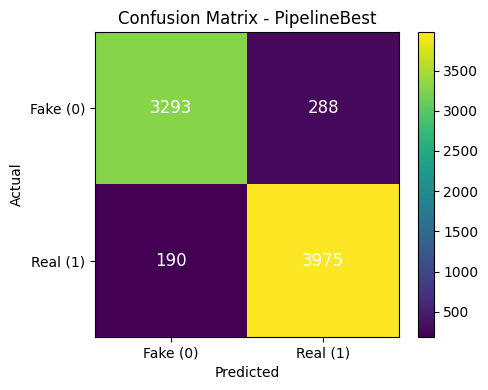

Best model: PipelineBest accuracy: 0.938290730699716
ROC AUC: 0.9846737466279446


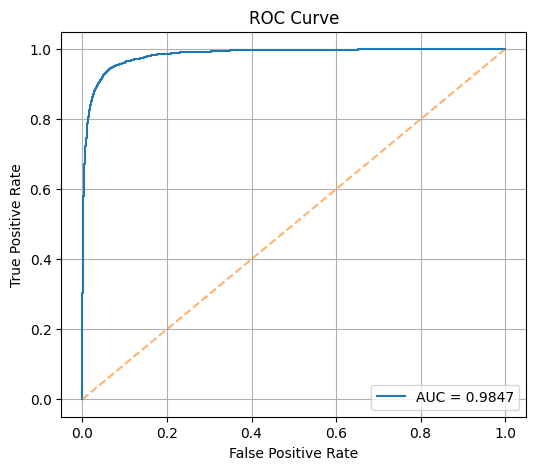

PR AUC: 0.9870653012806125


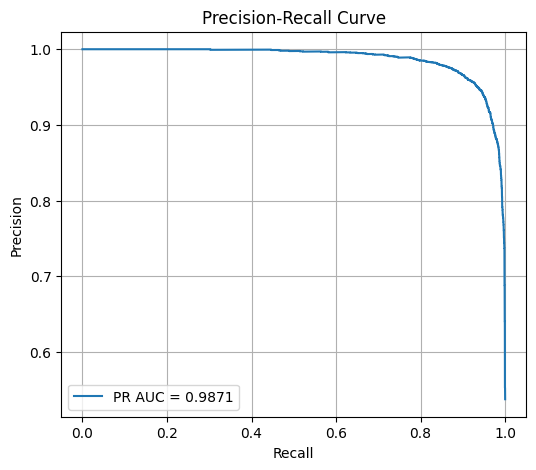

In [11]:
# CELL 6 (REPLACE) - Confusion matrix + ROC AUC + PR curve + print key metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score

# Confusion matrix (from results dict)
cm = results[best_name]['cm']
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title(f'Confusion Matrix - {best_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0,1], ['Fake (0)', 'Real (1)'])
plt.yticks([0,1], ['Fake (0)', 'Real (1)'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=12)
plt.colorbar(); plt.tight_layout(); plt.show()

print("Best model:", best_name, "accuracy:", results[best_name]['acc'])

# ROC AUC and Precision-Recall (if predict_proba available)
pipe = best_pipeline
if hasattr(pipe, "predict_proba"):
    y_proba = pipe.predict_proba(X_test_text)[:,1]
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", roc_auc)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5)); plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}"); plt.plot([0,1],[0,1],'--',alpha=0.6)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend(); plt.grid(True); plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print("PR AUC:", pr_auc)
    plt.figure(figsize=(6,5)); plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend(); plt.grid(True); plt.show()
else:
    print("predict_proba not available for the selected pipeline classifier; skipping ROC/PR.")


Top features for the trained Logistic Regression

Top features (REAL, class=1):
 ['says' 'factbox' 'china' 'senate' 'house' 'talks' 'myanmar' 'eu'
 'lawmakers' 'urges' 'brexit' 'turkey' 'german' 'south' 'exclusive'
 'rohingya' 'islamic state' 'minister' 'pm' 'probe']

Top features (FAKE, class=0):
 ['video' 'hillary' 'watch' 'gop' 'breaking' 'us' 'tweets' 'details'
 'america' 'racist' 'muslim' 'black' 'obama' 'president trump' 'images'
 'bernie' 'isis' 'audio' 'like' 'bombshell']


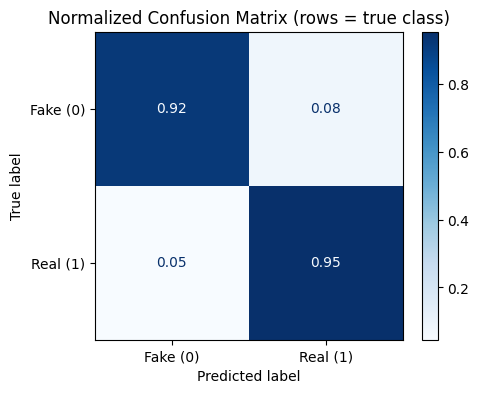

In [16]:
# ----- Insert after Cell 6: Top features + normalized confusion matrix -----
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Top features (if LR is the chosen classifier in the pipeline)
try:
    clf = best_pipeline.named_steps['clf']
    vec = best_pipeline.named_steps['tfidf']
    if hasattr(clf, 'coef_'):
        feat_names = np.array(vec.get_feature_names_out())
        coefs = clf.coef_[0]
        top_real = feat_names[np.argsort(coefs)[-20:][::-1]]
        top_fake = feat_names[np.argsort(coefs)[:20]]
        print("Top features (REAL, class=1):\n", top_real)
        print("\nTop features (FAKE, class=0):\n", top_fake)
    else:
        print("Classifier in pipeline is not LogisticRegression (no coef_).")
except Exception as e:
    print("Could not extract top features:", e)

# Normalized confusion matrix (rows = true classes)
cm = results[best_name]['cm']
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Fake (0)','Real (1)'])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap='Blues', values_format='.2f')
plt.title('Normalized Confusion Matrix (rows = true class)')
plt.show()


Threshold tuning & calibration

Best threshold by F1 on test ~ 0.5428 with F1 = 0.9447


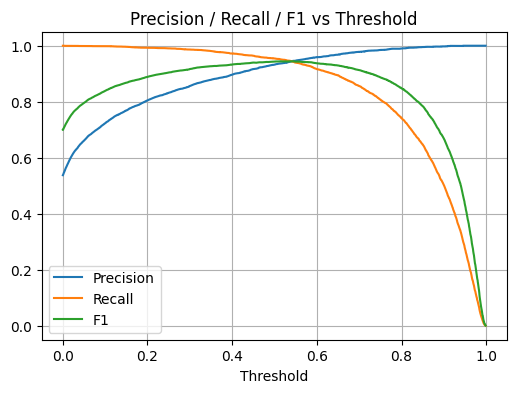

Metrics at suggested threshold:
Precision: 0.945633870579745
Recall   : 0.9438175270108043
F1       : 0.9447248257630377


In [17]:
# ----- Insert after top-features cell: Threshold tuning & optional calibration -----
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV

pipe = best_pipeline
if not hasattr(pipe, "predict_proba"):
    print("Model has no predict_proba — skipping threshold tuning.")
else:
    y_proba = pipe.predict_proba(X_test_text)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
    best_idx = np.nanargmax(f1_scores)
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    print(f"Best threshold by F1 on test ~ {best_thresh:.4f} with F1 = {f1_scores[best_idx]:.4f}")

    plt.figure(figsize=(6,4))
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.plot(thresholds, f1_scores[:-1], label='F1')
    plt.xlabel('Threshold')
    plt.legend(); plt.title('Precision / Recall / F1 vs Threshold'); plt.grid(True); plt.show()

    # Evaluate at the suggested threshold
    y_thresh_pred = (y_proba >= best_thresh).astype(int)
    print("Metrics at suggested threshold:")
    print("Precision:", precision_score(y_test, y_thresh_pred))
    print("Recall   :", recall_score(y_test, y_thresh_pred))
    print("F1       :", f1_score(y_test, y_thresh_pred))

    # Optional: calibrate classifier (uncomment to run; takes additional time)
    # print("Calibrating classifier with isotonic method (may take time)...")
    # calib = CalibratedClassifierCV(pipe.named_steps['clf'], method='isotonic', cv=3)
    # calib.fit(pipe.named_steps['tfidf'].transform(X_train_text), y_train)
    # # To use calibrated model within pipeline, you must rebuild pipeline with calib:
    # from sklearn.pipeline import make_pipeline
    # calibrated_pipeline = make_pipeline(pipe.named_steps['tfidf'], calib)
    # # Example: calibrated_pipeline.predict_proba(X_test_text)


Save best model + vectorizer & Inference example

In [12]:
# CELL 7 (REPLACE) - Save the full pipeline and run inference example using the saved pipeline
import joblib
import re

# Save best pipeline (includes TF-IDF + classifier)
joblib.dump(best_pipeline, "best_pipeline.joblib")
print("Saved pipeline to best_pipeline.joblib")

# You may still keep separate artifacts if you prefer, but pipeline is recommended.
# Inference example (use preprocess_text to match training)
pipe = joblib.load("best_pipeline.joblib")  # load to verify saved file works

sample_texts = [
    "Breaking: New research shows coffee increases lifespan, scientists stunned",
    "Government announces new policy to improve public healthcare next year"
]

processed = [preprocess_text(t) for t in sample_texts]
preds = pipe.predict(processed)
probs = pipe.predict_proba(processed) if hasattr(pipe, "predict_proba") else None

for i,t in enumerate(sample_texts):
    label = "Real" if preds[i]==1 else "Fake"
    prob_txt = f" (prob: {probs[i][1]:.4f})" if probs is not None else ""
    print(f"> {t}\n -> {label}{prob_txt}\n")


Saved pipeline to best_pipeline.joblib
> Breaking: New research shows coffee increases lifespan, scientists stunned
 -> Fake (prob: 0.1568)

> Government announces new policy to improve public healthcare next year
 -> Real (prob: 0.8010)



It saves requirements.txt and a small model_metadata.json recording best params & date.

In [19]:
# Safe metadata save (replace previous metadata cell)
import json
import datetime
from pathlib import Path

# Helper to make arbitrary objects JSON-serializable by converting
# estimator objects and other non-serializable values to readable strings.
def make_json_safe(obj):
    try:
        # try a quick json dump to see if it's serializable
        json.dumps(obj)
        return obj
    except TypeError:
        # For sklearn estimators / classes: return class name
        try:
            if hasattr(obj, "__class__"):
                return obj.__class__.__name__
        except Exception:
            pass
        # Fallback to string representation (short)
        try:
            s = str(obj)
            # truncate if it's very long
            return s if len(s) <= 200 else s[:200] + "..."
        except Exception:
            return repr(obj)

# Collect fields safely
saved_at = datetime.datetime.now(datetime.timezone.utc).isoformat()
raw_best_params = getattr(gs, "best_params_", None)
# If best_params_ is a dict, sanitize each value
if isinstance(raw_best_params, dict):
    safe_best_params = {k: make_json_safe(v) for k, v in raw_best_params.items()}
else:
    safe_best_params = make_json_safe(raw_best_params)

cv_best_score = None
if hasattr(gs, "best_score_") and gs.best_score_ is not None:
    try:
        cv_best_score = float(gs.best_score_)
    except Exception:
        cv_best_score = make_json_safe(gs.best_score_)

meta = {
    "saved_at": saved_at,
    "best_params": safe_best_params,
    "cv_best_score": cv_best_score,
    "model_name": "best_pipeline.joblib"
}

Path("model_metadata.json").write_text(json.dumps(meta, indent=2))
print("Saved model_metadata.json")
print(json.dumps(meta, indent=2))

# Optional: create requirements.txt (uncomment if you want it)
# NOTE: this writes the entire environment and may be large.
# !pip freeze > requirements.txt
# print("Saved requirements.txt")


Saved model_metadata.json
{
  "saved_at": "2025-12-12T10:44:01.635668+00:00",
  "best_params": {
    "clf": "LogisticRegression",
    "clf__C": 1.0,
    "clf__class_weight": "balanced",
    "tfidf__max_features": 10000,
    "tfidf__ngram_range": [
      1,
      2
    ]
  },
  "cv_best_score": 0.9428241227443326,
  "model_name": "best_pipeline.joblib"
}
